#  Simulating an economy using a VAR(1) model

In [83]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as skm
from statsmodels.tsa.arima.model import ARIMA

In [38]:
# init variables
mu = 0.02
phi = 0.9
std_gamma = 1.5
mean_gamma = 5
std_d = 0.12
rho = 0.96
r_f = 0.01

In [39]:
n = 10000
delta_d_errors = np.random.normal(0, std_d, n)
gamma_errors = np.random.normal(0, std_gamma, n)
delta_d_series = []
gamma_series = [mean_gamma]
pd_series = []
return_series = []

def append_pd_series(i, r_f, mean_gamma, std_d, rho, gamma_series, phi, mu):
    discount_rate = (r_f + (mean_gamma * std_d * std_d))/(1 - rho)
    discount_rate += (std_d * std_d * (gamma_series[i] - mean_gamma))/(1 - (rho * phi))
    pd_unit = mu/(1 - rho)
    pd_unit -= discount_rate
    pd_series.append(pd_unit)

for i in range(n):
    delta_d_series.append(mu + delta_d_errors[i])
    gamma_series.append(mean_gamma + phi * (gamma_series[i] - mean_gamma) + gamma_errors[i])
    append_pd_series(i, r_f, mean_gamma, std_d, rho, gamma_series, phi, mu)
    if(i>=1):
        return_series.append((pd_series[i] * rho) - pd_series[i-1] + delta_d_series[i-1])

append_pd_series(n, r_f, mean_gamma, std_d, rho, gamma_series, phi, mu)
return_series.append((pd_series[n] * rho) - pd_series[n-1] + delta_d_series[n-1])
#print(len(return_series))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


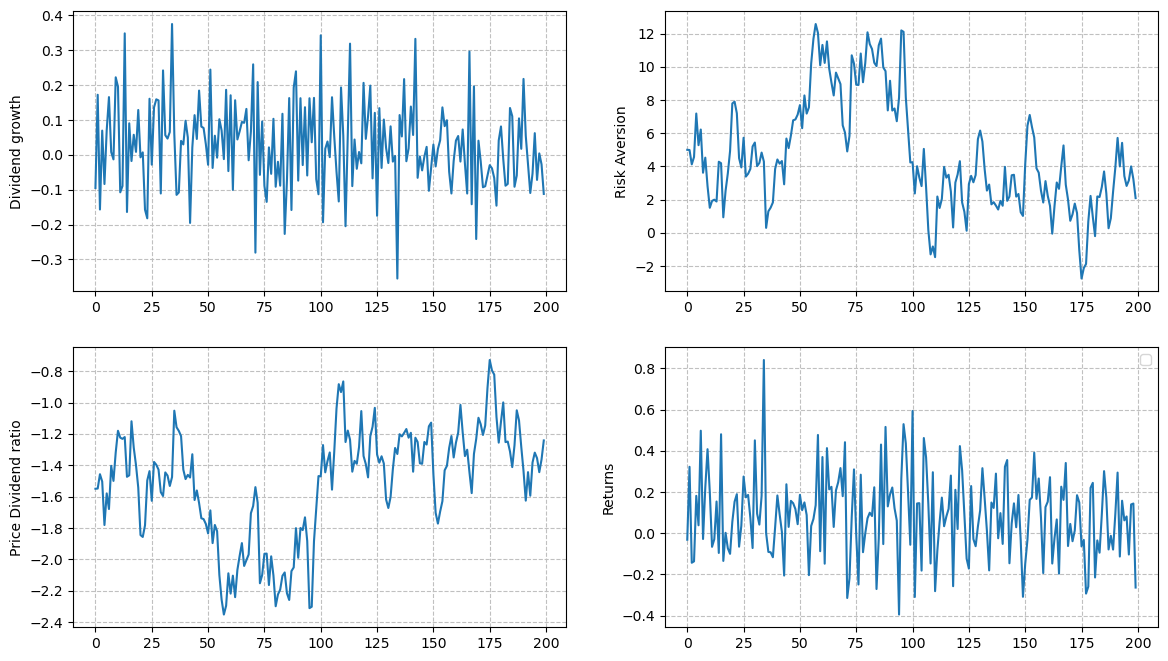

In [40]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.grid(linestyle="--", color="silver")
plt.ylabel("Dividend growth")
plt.plot(delta_d_series[:200])

plt.subplot(2,2,2)
plt.grid(linestyle="--", color="silver")
plt.ylabel("Risk Aversion")
plt.plot(gamma_series[:200])

plt.subplot(2,2,3)
plt.grid(linestyle="--", color="silver")
plt.ylabel("Price Dividend ratio")
plt.plot(pd_series[:200])

plt.subplot(2,2,4)
plt.grid(linestyle="--", color="silver")
plt.ylabel("Returns")
plt.plot(return_series[:200])

plt.legend()
plt.show()

In [48]:
df = pd.DataFrame()
df["returns"] = return_series
df["pd_ratio"] = pd_series[1:]
df["dividend_growth"] = delta_d_series
model = VAR(df).fit(maxlags=1)
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 20, Feb, 2023
Time:                     15:50:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -45.6495
Nobs:                     9999.00    HQIC:                  -45.6552
Log likelihood:           185716.    FPE:                1.48228e-20
AIC:                     -45.6581    Det(Omega_mle):     1.36472e-20
--------------------------------------------------------------------
Results for equation returns
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.124267         0.008474          -14.664           0.000
L1.returns                -0.000210         0.012233           -0.017           0.986
L1.pd_ratio               -0.134744   

In [15]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        
adfuller_test(df["returns"], name="Returns")
adfuller_test(df["pd_ratio"], name="Price Dividend")
adfuller_test(df["dividend_growth"], name="Dividend growth")

    Augmented Dickey-Fuller Test on "Returns" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -36.8032
 No. Lags Chosen       = 8
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "Price Dividend" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.3323
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "Dividend growth" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

### R Squared values for the VAR(1) model

In [51]:
skm.r2_score(model.fittedvalues['returns']+model.resid['returns'],
  model.fittedvalues['returns'])

0.06239648066511261

In [52]:
skm.r2_score(model.fittedvalues['pd_ratio']+model.resid['pd_ratio'],
  model.fittedvalues['pd_ratio'])

0.8174841851256014

In [53]:
skm.r2_score(model.fittedvalues['dividend_growth']+model.resid['dividend_growth'],
  model.fittedvalues['dividend_growth'])

0.00020595600351158705

## Miscellaneous analytics

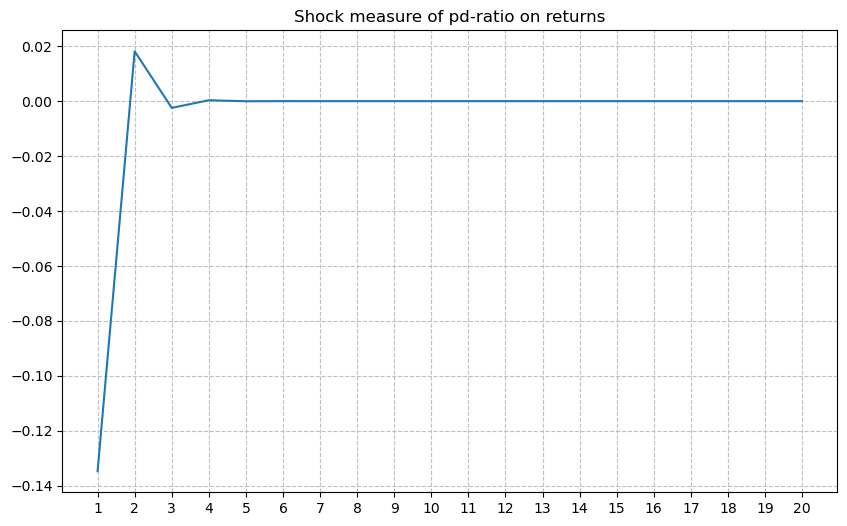

In [67]:
phi1 = -0.134744
series = []
for j in range(1,21):
    series.append(phi1 ** j)

plt.figure(figsize=(10,6))
plt.title("Shock measure of pd-ratio on returns")
plt.grid(linestyle="--", color="silver")
plt.plot(range(1,21), series)
plt.xticks(range(1,21))
plt.show()

In [69]:
df_fc = pd.DataFrame()
df_fc["pd_ratio"] = model.fittedvalues["pd_ratio"]
df_fc["returns"] = model.fittedvalues["returns"]
df_fc["dividend_growth"] = model.fittedvalues["dividend_growth"]
df_fc

,pd_ratio,returns,dividend_growth
1,-1.549870,0.083752,0.022909
2,-1.462619,0.073232,0.020115
3,-1.510417,0.077326,0.023253
4,-1.756485,0.116286,0.021100
5,-1.578270,0.087944,0.023515
...,...,...,...
9995,-0.793749,-0.029389,0.021000
9996,-0.994655,0.001282,0.020144
9997,-0.902428,-0.012667,0.020797
9998,-1.016600,0.006102,0.018756


In [72]:
df_fc["returns"].corr(rho * df_fc["pd_ratio"] - df_fc["pd_ratio"].shift(1))

-0.13085616276806605

In [74]:
df_fc["r(k=1)"] = df_fc["returns"] + df_fc["returns"].shift(-1)
df_fc["r(k=2)"] = df_fc["returns"] + df_fc["returns"].shift(-1) + df_fc["returns"].shift(-2)
df_fc["r(k=3)"] = df_fc["returns"] + df_fc["returns"].shift(-1) + df_fc["returns"].shift(-2) + df_fc["returns"].shift(-3)
df_fc["r(k=4)"] = df_fc["returns"] + df_fc["returns"].shift(-1) + df_fc["returns"].shift(-2) + df_fc["returns"].shift(-3) + df_fc["returns"].shift(-4)
df_fc["r(k=5)"] = df_fc["returns"] + df_fc["returns"].shift(-1) + df_fc["returns"].shift(-2) + df_fc["returns"].shift(-3) + df_fc["returns"].shift(-4) + df_fc["returns"].shift(-5)
df_fc

,pd_ratio,returns,dividend_growth,r(k=1),r(k=2),r(k=3),r(k=4),r(k=5)
1,-1.549870,0.083752,0.022909,0.156984,0.234310,0.350596,0.438540,0.541046
2,-1.462619,0.073232,0.020115,0.150558,0.266844,0.354788,0.457294,0.523242
3,-1.510417,0.077326,0.023253,0.193612,0.281556,0.384062,0.450010,0.527919
4,-1.756485,0.116286,0.021100,0.204230,0.306736,0.372684,0.450594,0.503797
5,-1.578270,0.087944,0.023515,0.190450,0.256398,0.334308,0.387511,0.423733
...,...,...,...,...,...,...,...,...
9995,-0.793749,-0.029389,0.021000,-0.028107,-0.040774,-0.034672,-0.040887,NaN
9996,-0.994655,0.001282,0.020144,-0.011385,-0.005283,-0.011497,NaN,NaN
9997,-0.902428,-0.012667,0.020797,-0.006565,-0.012780,NaN,NaN,NaN
9998,-1.016600,0.006102,0.018756,-0.000113,NaN,NaN,NaN,NaN


In [86]:
arma1 = ARIMA(df_fc["returns"], order=(1, 0, 1)).fit(cov_type='robust')
arma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 9999
Model:                 ARIMA(1, 0, 1)   Log Likelihood               24301.395
Date:                Mon, 20 Feb 2023   AIC                         -48594.791
Time:                        17:44:23   BIC                         -48565.950
Sample:                             0   HQIC                        -48585.028
                               - 9999                                         
Covariance Type:               robust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0833      0.002     37.532      0.000       0.079       0.088
ar.L1          0.9050      0.005    190.974      0.000       0.896       0.914
ma.L1         -0.0076      0.011     -0.695      0.487      -0.029       0.014
sigma2         0.0005   6.32e-06     71.741      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.41
Prob(Q):                              1.00   Prob(JB):                         0.30
Heteroskedasticity (H):               1.01   Skew:                             0.02
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

In [88]:
skm.r2_score(arma1.fittedvalues+arma1.resid,
  arma1.fittedvalues)

0.8162460673391103